In [9]:
%matplotlib inline

In [10]:
import numpy as np
from astropy import units as u

In [11]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [12]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube

In [13]:
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/imaging_results")

# Below here is experimentation with CASA

Examine the phases: this uses `casatools` (which is only available as a beta library from an NRAO site) to load the table and plot some simple phase information.

In [14]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [17]:
with CasaTable('../W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_phase1_int.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [18]:
# data are complex numbers; we're interested in the phase angle
angle = np.angle(data) * 180/np.pi

Plot the phase angle correction from the calibration table vs. entry number.  This allows us to see the typical phase correction split by observation ID rather than by time, since it's very hard to see anything in the angle vs. time plot when multiple independent observations are involved.

In [19]:
uobsids = np.unique(obsid)
nobsids = len(uobsids)
print(nobsids)

13


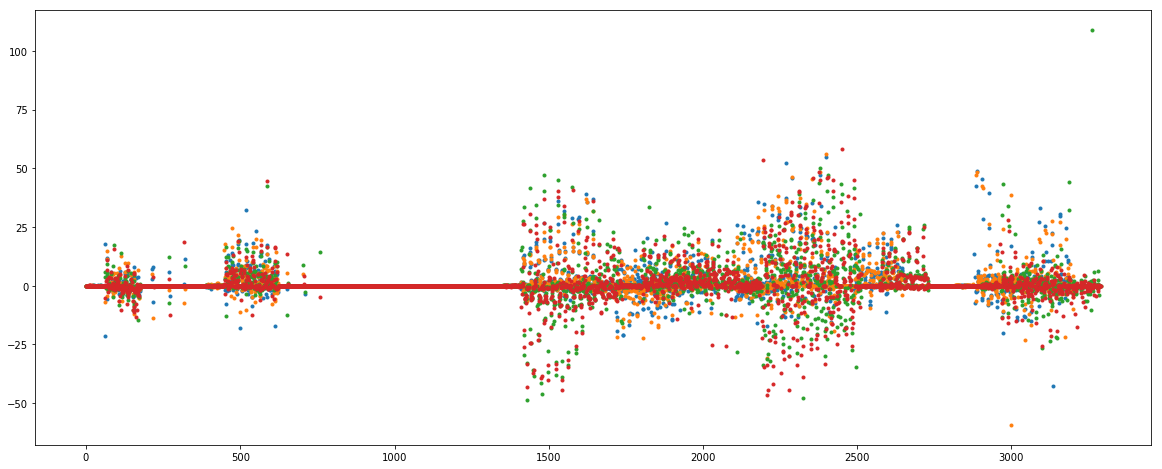

In [20]:
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==0)].T, marker='.', linestyle='none')
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==1)].T, marker='.', linestyle='none')

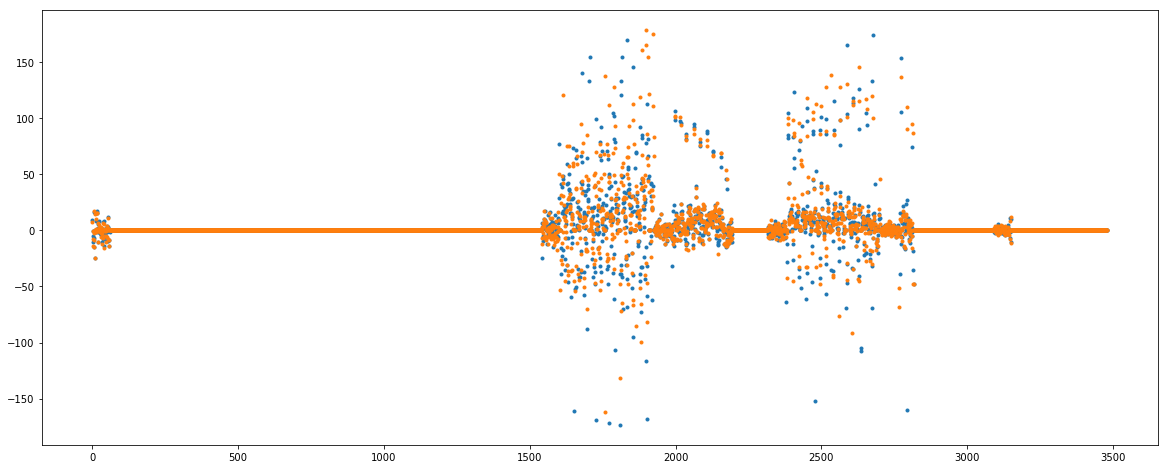

In [21]:
pl.plot(angle[:,0,(antenna1 == 2) & (spwid%13==3)].T, marker='.', linestyle='none')

In [22]:
uantid = np.unique(antenna1)
nants = len(uantid)
print(nants)

83


In [23]:
anglecube = angle.reshape([2,1,antenna1.size//nants,nants])

This creates a "waterfall plot" of scan number on the y-axis vs antenna number on the x-axis.  You can then see the breakdown by what looks like 7m (lots of scans, few antennae), TM1 (medium # of scans) and TM2 (few scans)

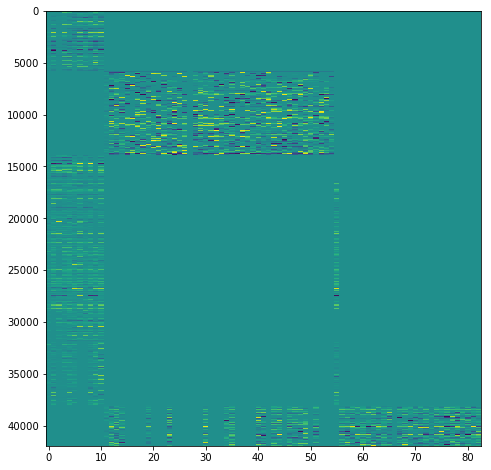

In [24]:
pl.imshow(anglecube[0,0,:,:], aspect=anglecube.shape[3]/anglecube.shape[2])

Because this is a live CASA notebook, we can do a gaincal with amplitude just to see what's going on.

However, I don't recommend this because gaincal takes too long.

In [16]:
from casatasks import gaincal

This took about 2 hours, which is not very good.

In [51]:
import selfcal_heuristics

In [32]:
with CasaTable('test_amplitude_gains_B6_W51E.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    snr = tb.getcol('SNR')    
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [52]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions('test_amplitude_gains_B6_W51E.cal', minsnr=5)

In [33]:
amp = np.abs(data)

In [53]:
fids = np.unique(fieldid)
print(fids, okfields, notokfields)

[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37] [16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36] [11, 12, 13, 14, 15, 19, 24, 33, 34, 37]


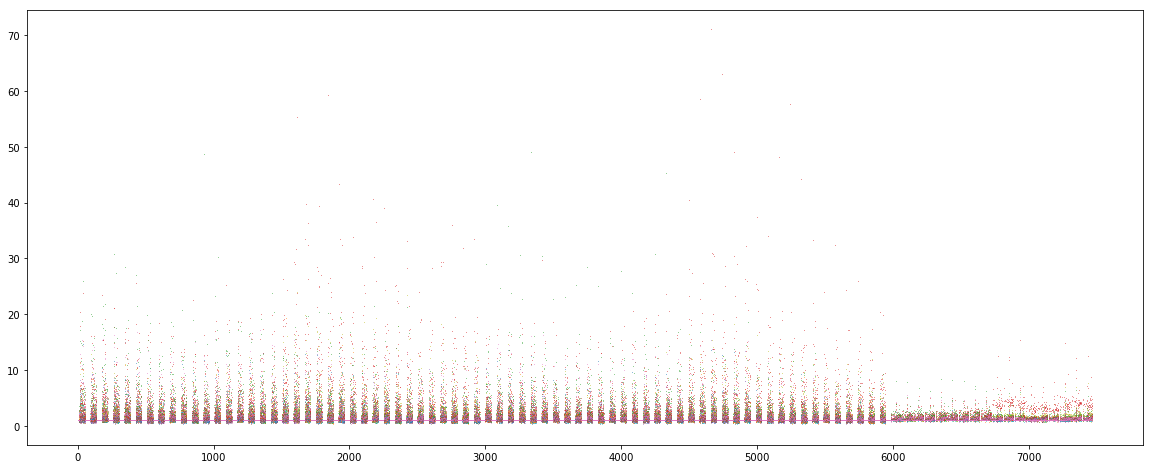

In [35]:
for fid in fids:
    pl.plot(amp[0,0,fieldid==fid], marker=',', linestyle='none', alpha=0.5)

Histograms of the amplitude correction factors.  Note that I exclude ``amplitude == 1`` because those are presumably no-solution points.

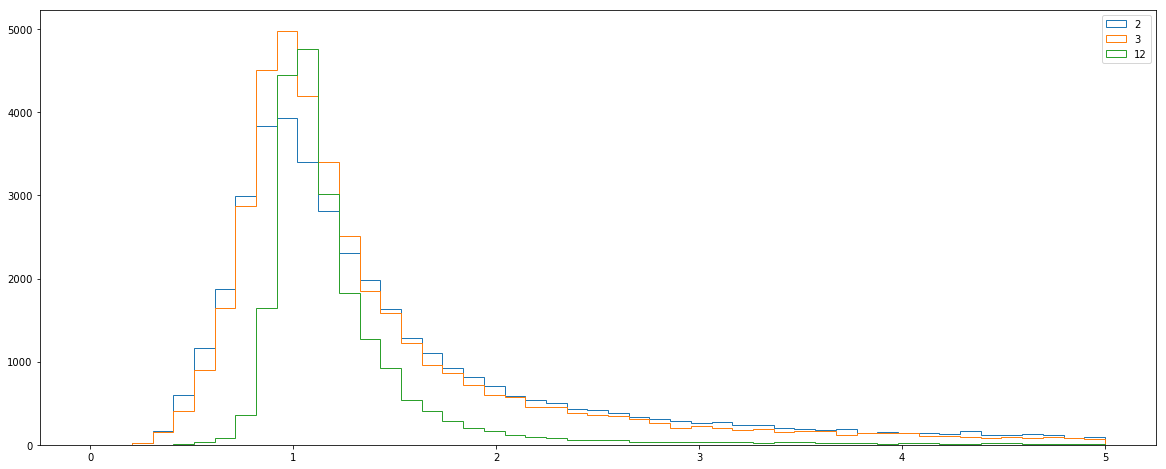

In [37]:
for oid in np.unique(obsid):
    
    dd = amp[0,0,obsid==oid]
    ok = (dd!=1) & (dd!=0)
    pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=str(oid))
pl.legend(loc='best')

### Histograms of the calibrated amplitude for each antenna and each field

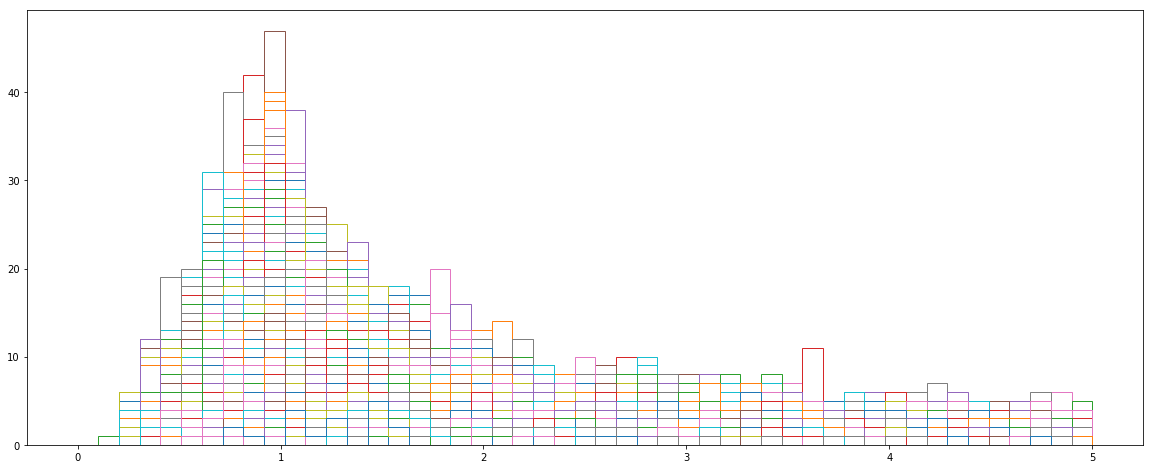

In [38]:
pl.clf()
for aid in np.unique(antenna1):
    for ii,fid in enumerate(fids):
        msk = (antenna1==aid) & (fieldid==fid)
        if np.any(msk):
            dd = amp[0,0,msk]
            ok = (dd!=1) & (dd!=0)
            pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=f"{aid}_{fid}")
#pl.legend(loc='best')

### Amplitude correction vs. time for each of the first 15 antennae in obs #2, spw #16.  Colored by antenna number, each panel is a different field

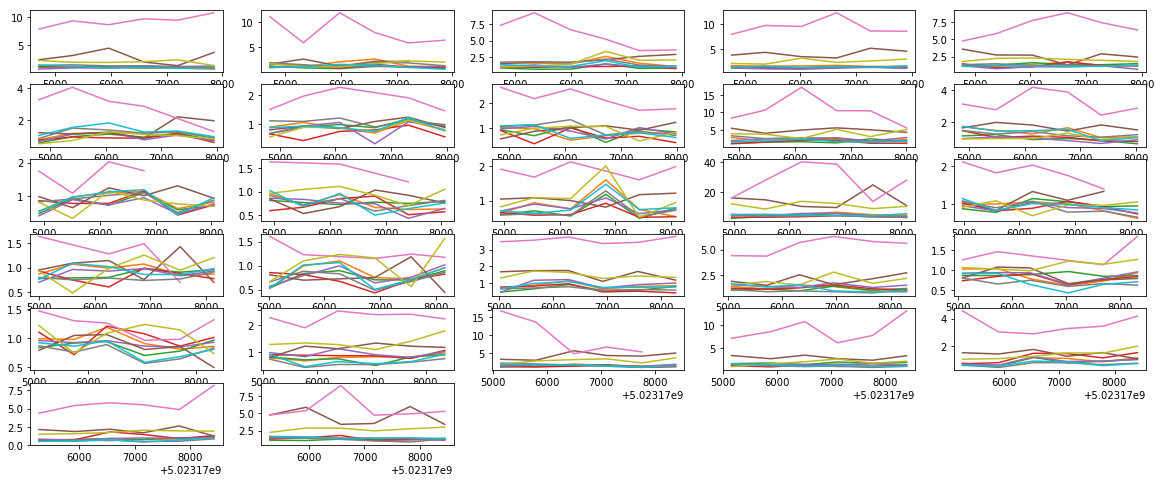

In [39]:
pl.clf()
for aid in np.unique(antenna1)[:20]:
    for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
        ax = pl.subplot(6,5,ii+1)
        msk = (antenna1==aid) & (obsid==2) & (spwid == 16) & (fieldid==fid)
        if np.any(msk):
            dd = amp[0,0,msk]
            tm = time[msk]
            m2 = dd!=1
            srt = np.argsort(tm)
            ax.plot(tm[srt[m2]], dd[srt[m2]])
#pl.legend(loc='best')

Note above the substantial per-field differences!

### Per-field histograms of the amplitude gains

In [41]:
print("There are {0} fields (pointings) in observation 2".format(len(np.unique(fieldid[obsid==2]))))

There are 29 fields (pointings) in observation 2


In [44]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import casatools
w51e2 = SkyCoord('19:23:43.939 +14:30:34.472', frame='fk5', unit=(u.hour, u.deg))
separation = {}
msmd = casatools.msmetadata()
msmd.open("../W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_selfcal.ms")
for fid in msmd.fieldsforname('W51-E'):
    crd = msmd.phasecenter(fid)
    field_coord = SkyCoord(crd['m0']['value'], crd['m1']['value'],
                           frame=crd['refer'].lower(),
                           unit=(crd['m0']['unit'], crd['m1']['unit']))
    separation[fid] = w51e2.separation(field_coord)
msmd.close()

True

fid=11  mean=2.3071979956868094  median=1.6543906927108765  rms=1.7317678737582747
fid=12  mean=2.3379422886165107  median=1.7863968014717102  rms=1.7667796559271676
fid=13  mean=2.2343454543282  median=1.6803148984909058  rms=1.7918131480549333
fid=14  mean=2.674089258978803  median=1.9898226261138916  rms=1.9386383366989068
fid=15  mean=2.0735099294770087  median=1.484976053237915  rms=1.510010287589033
fid=16  mean=1.3542363731300129  median=1.2138562202453613  rms=0.6500476988931231
fid=17  mean=1.0466568544212538  median=0.9770480394363403  rms=0.36978448913037143
fid=18  mean=1.0813482887318162  median=0.9937896728515625  rms=0.4600921168720623
fid=19  mean=4.17233009962365  median=2.9069751501083374  rms=3.4591215439624445
fid=20  mean=1.357141332751582  median=1.1062121391296387  rms=0.745809011339669
fid=21  mean=0.9145128378283837  median=0.887941837310791  rms=0.2944874352897049
fid=22  mean=0.8720895439386368  median=0.8437615931034088  rms=0.2582455178636918
fid=23  mean=0

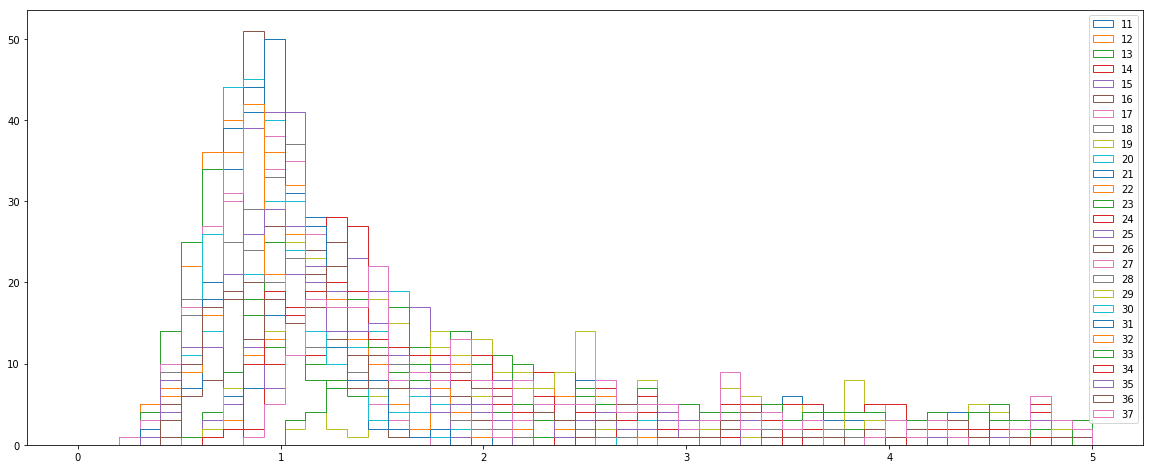

In [45]:
pl.clf()
fldstats = {}
for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
    msk = (obsid==2) & (spwid == 16) & (fieldid==fid)
    if np.any(msk):
        dd = amp[0,0,msk]
        ok = (dd!=0) & (dd!=1)
        pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=f"{fid}")
        print(f"fid={fid}  mean={dd[ok].mean()}  median={np.median(dd[ok])}  rms={dd[ok].std()}")
        fldstats[fid] = [dd[ok].mean(), np.median(dd[ok]), dd[ok].std()]
pl.legend(loc='best')

<Container object of 3 artists>

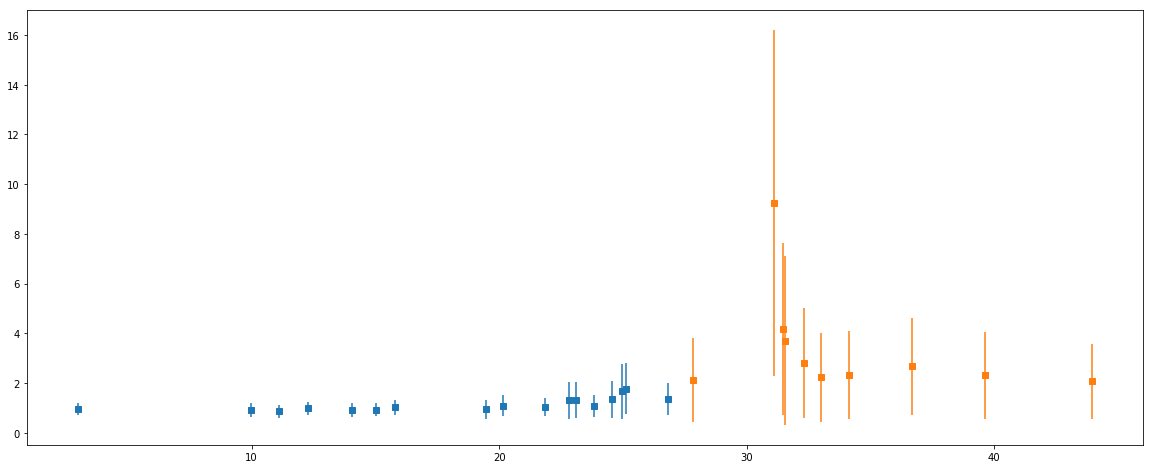

In [54]:
pl.errorbar([separation[x].to(u.arcsec).value for x in okfields],
            [fldstats[x][0] for x in okfields],
            yerr=[fldstats[x][2] for x in okfields],
            linestyle='none', marker='s')
pl.errorbar([separation[x].to(u.arcsec).value for x in notokfields],
            [fldstats[x][0] for x in notokfields],
            yerr=[fldstats[x][2] for x in notokfields],
            linestyle='none', marker='s')

<Container object of 3 artists>

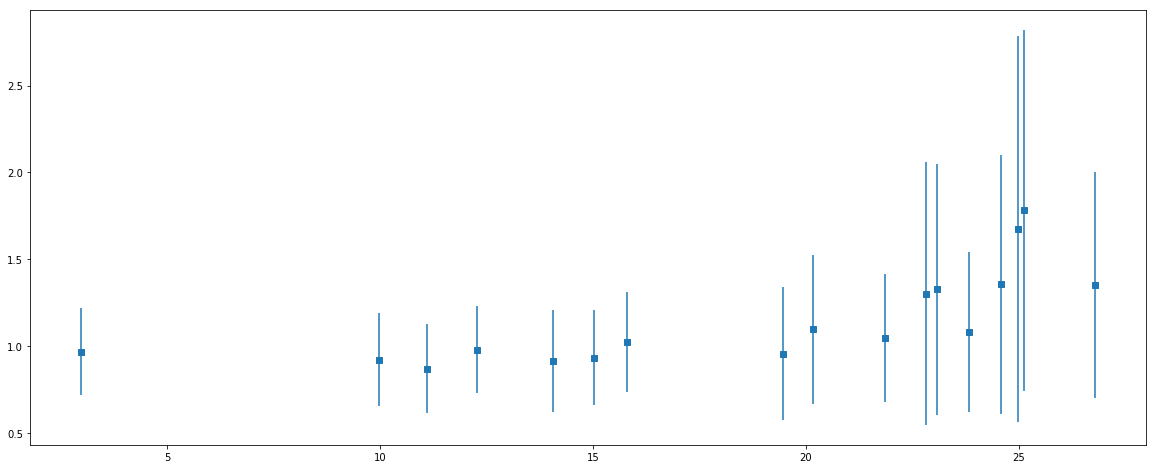

In [55]:
pl.errorbar([separation[x].to(u.arcsec).value for x in okfields],
            [fldstats[x][0] for x in okfields],
            yerr=[fldstats[x][2] for x in okfields],
            linestyle='none', marker='s')

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f260da67860>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f260c384e10>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f25ff7a88d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f25ff7ae2b0>}

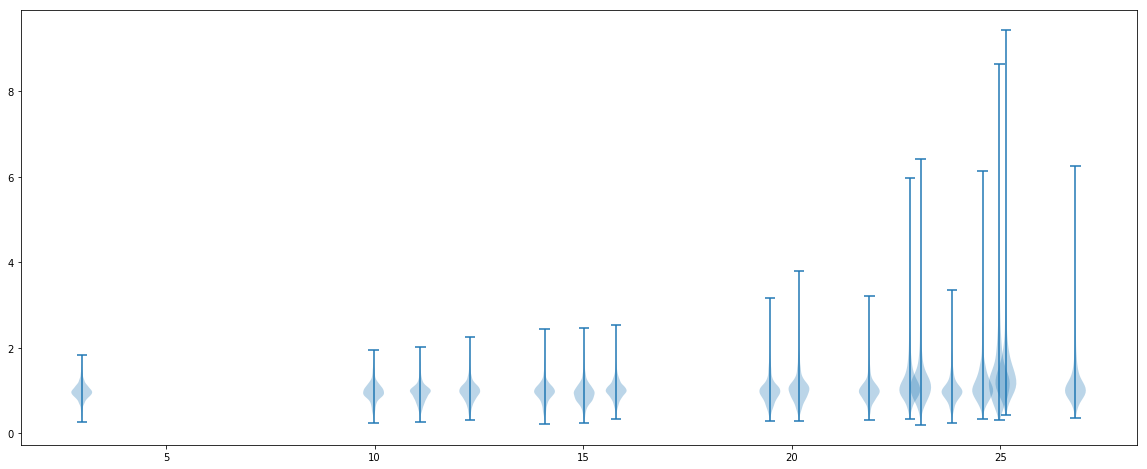

In [59]:
pl.violinplot(dataset=[amp[0,0,(amp[0,0,:]!=1) & (fieldid == fid)] for fid in okfields],
              positions=[separation[x].to(u.arcsec).value for x in okfields])

In [65]:
obsid

array([ 2,  2,  2, ..., 12, 12, 12], dtype=int32)

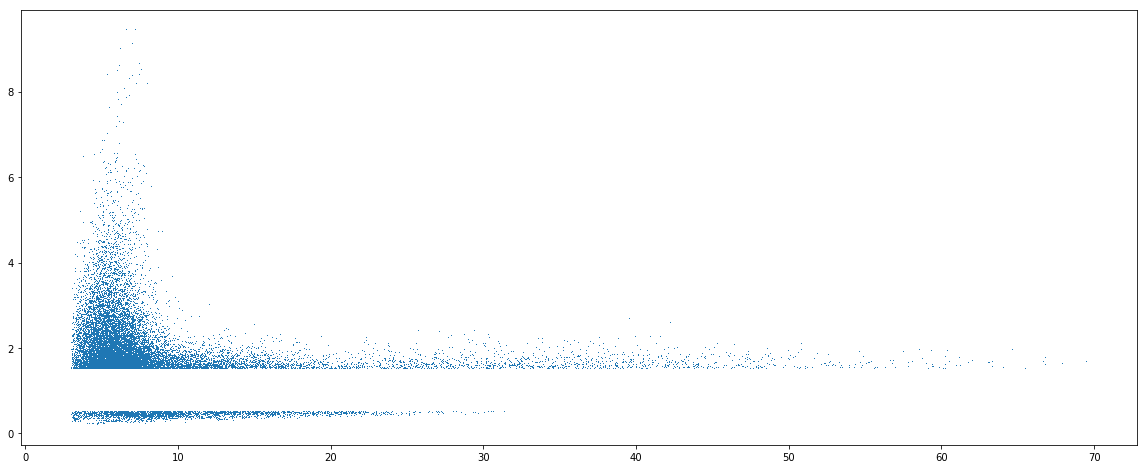

In [68]:
msk = ((amp > 1.5) | (amp < 0.5)) & np.isin(fieldid, okfields)
pl.plot(snr[msk],
        amp[msk],
        ',')

In [1]:
import holoviews as hv
hv.extension('bokeh')

ModuleNotFoundError: No module named 'holoviews'

In [71]:
hv.Scatter(snr[msk], amp[msk])

ValueError: kdims argument expects a Dimension or list of dimensions, specified as tuples, strings, dictionaries or Dimension instances, not a ndarray type. Ensure you passed the data as the first argument.